In [1]:
!pip install ipeadatapy
!pip install prophet

In [2]:
# biblios genéricas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as qqplot
import random
import os

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Estatísticas de ajuste:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Holt-Winters para tentar simular tendência!
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import requests

In [3]:
from prophet import Prophet

1. Puxando a série IBOV

In [50]:
# Puxando o IBOVESPA

ibov = pd.read_csv(
    './Bovespa Historical Data.csv'
)

ibov = ibov[[
    'Date', 'Price', 'Change %'
]]

ibov['Date'] = pd.to_datetime(
    ibov['Date'], format = '%m/%d/%Y'
)

ibov = ibov.sort_values(by = 'Date').reset_index(drop = True)

ibov['Price'] = ibov['Price'].str.replace('.', 'x', regex = False).str.replace(',', '.', regex = False).str.replace('x', '', regex = False)
ibov['Price'] = ibov['Price'].astype(float)

ibov['diff_1'] = ibov['Price'].pct_change()

ibov = ibov.rename(
    columns={
        'Price':'IBOV'
    }
)

ibov_select = ibov[[
    'Date', 'IBOV'
]]

ibov.tail()

,Date,IBOV,Change %,diff_1
46,2024-11-01,125.668,-3.12%,-0.031184
47,2024-12-01,120.283,-4.28%,-0.042851
48,2025-01-01,126.135,4.86%,0.048652
49,2025-02-01,122.799,-2.64%,-0.026448
50,2025-03-01,130.260,6.08%,0.060758


In [51]:
## Train split do merge sem diff
size_treino = int(len(ibov) -6)
train_ndiff = ibov.iloc[:size_treino]
test_ndiff = ibov.iloc[size_treino:]

In [52]:
train_ibov = train_ndiff[[
    'Date','IBOV'
]].reset_index(drop = True)

In [53]:
train_ibov['y'] = train_ibov['IBOV']
train_ibov['ds'] = pd.to_datetime(train_ibov['Date'])

train_ibov.tail()

,Date,IBOV,y,ds
40,2024-05-01,122.098,122.098,2024-05-01
41,2024-06-01,123.907,123.907,2024-06-01
42,2024-07-01,127.652,127.652,2024-07-01
43,2024-08-01,136.004,136.004,2024-08-01
44,2024-09-01,131.816,131.816,2024-09-01


2. Modelo Prophet; Benchmark

In [54]:
model = Prophet()

model.fit(train_ibov)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24jn69sp/abe46drx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24jn69sp/0rsiq_ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60244', 'data', 'file=/tmp/tmp24jn69sp/abe46drx.json', 'init=/tmp/tmp24jn69sp/0rsiq_ur.json', 'output', 'file=/tmp/tmp24jn69sp/prophet_modelfflzc_dr/prophet_model-20250513225836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:58:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
last_date = train_ibov['ds'].max()

future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=6, freq='MS')

future = pd.DataFrame({'ds': future_dates})

# concat
future = pd.concat([train_ibov, future], ignore_index=True)

In [56]:
forecast_prophet = model.predict(future)

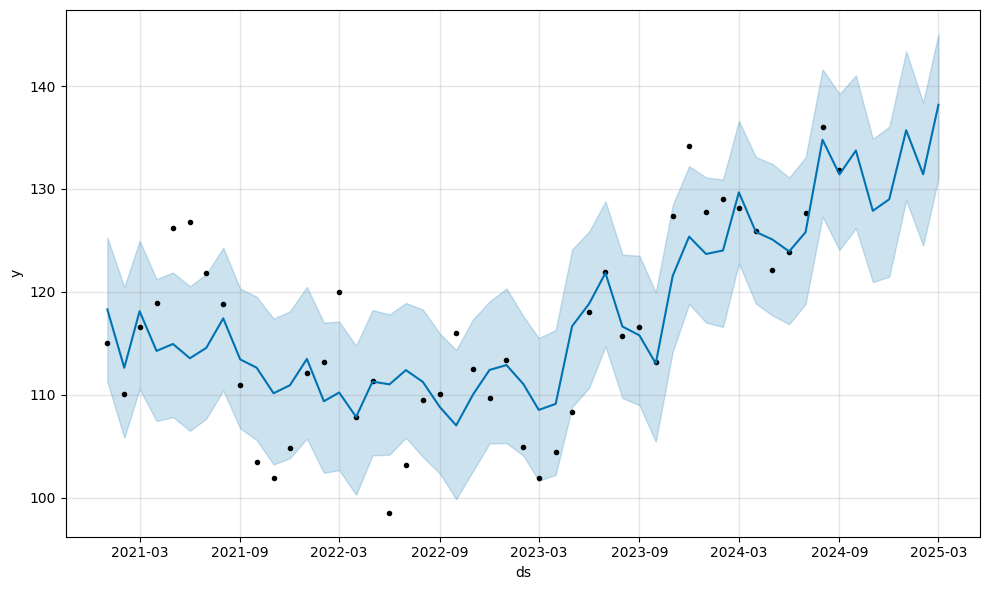

In [57]:
model.plot(forecast_prophet)
plt.show()

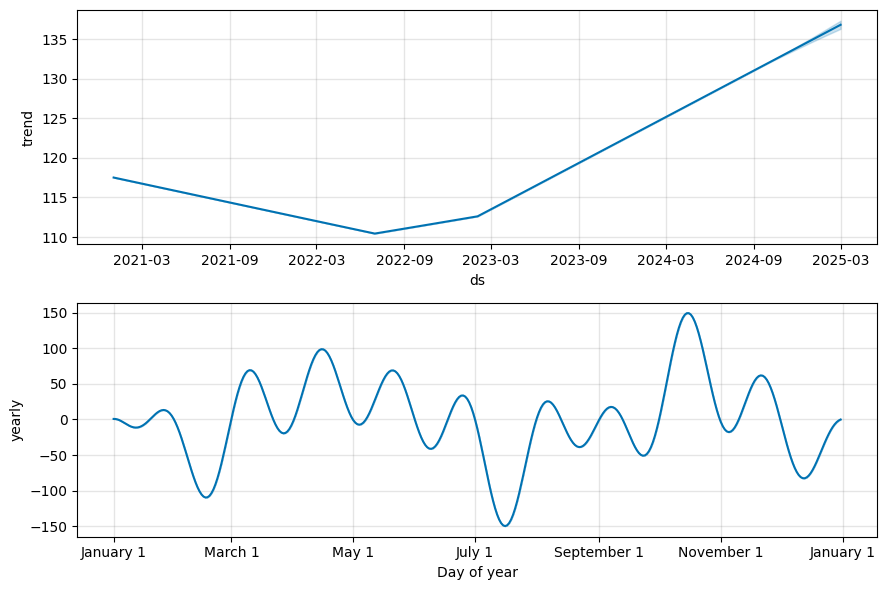

In [58]:
model.plot_components(forecast_prophet)
plt.show()

In [59]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [60]:
forecast_prophet[['ds', 'yhat']].head()

,ds,yhat
0,2021-01-01,118.298523
1,2021-02-01,112.628262
2,2021-03-01,118.120018
3,2021-04-01,114.265322
4,2021-05-01,114.939443


In [61]:
train_ndiff.reset_index(inplace = True)

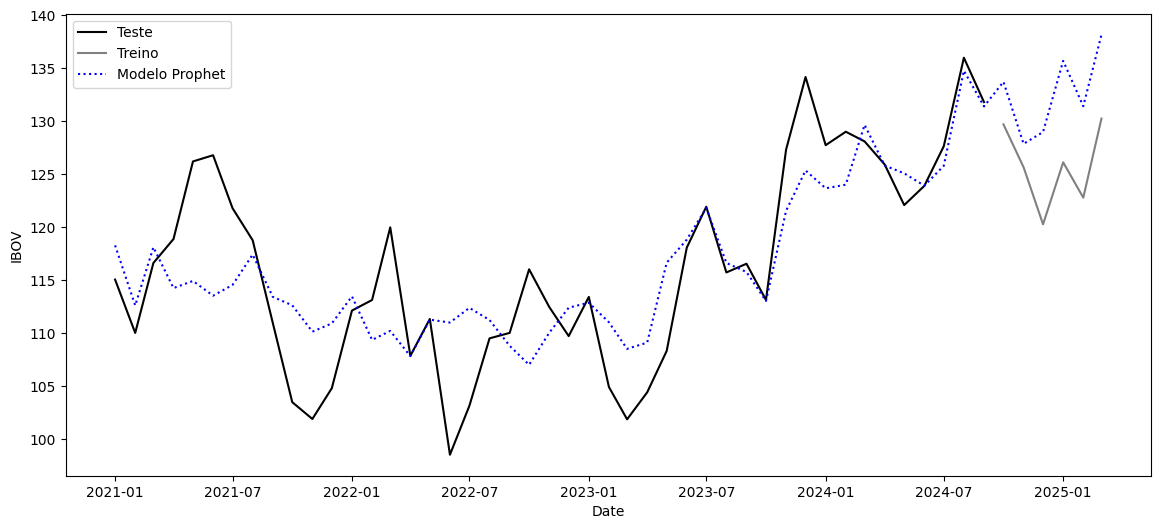

In [62]:
plt.figure(figsize = (14,6))

sns.lineplot(
    data = train_ndiff,
    label = 'Teste',
    color = 'black',
    x='Date',
    y='IBOV'
)

sns.lineplot(
    data = test_ndiff,
    label = 'Treino',
    color = 'grey',
    x='Date',
    y='IBOV'
)

sns.lineplot(
    data = forecast_prophet,
    label = 'Modelo Prophet',
    color = 'blue',
    linestyle = 'dotted',
    x='ds',
    y='yhat'
)

plt.show()

In [63]:
print(mean_squared_error(
    forecast[forecast['ds'] >= test_ndiff['Date'].iloc[0]]['yhat'], test_ndiff['IBOV']
))

KeyError: 'ds'

3. Testando a efetividade de um Holt-Winters, visto que captura tendência + sazonalidade

In [64]:
# Criando o Modelo
model_HW = ExponentialSmoothing(
    train_ndiff['IBOV'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)

In [65]:
train_ndiff['fitted'] = model_HW.fittedvalues
forecast = model_HW.forecast(steps=6)

<ipython-input-65-210686c631ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ndiff['fitted'] = model_HW.fittedvalues


In [66]:
forecast

,0
45,129.844710
46,133.457820
47,136.380132
48,137.409880
49,134.239067
50,136.956290


In [67]:
fit_forecast = pd.concat([
    train_ndiff[[
    'Date', 'fitted'
]],
    pd.DataFrame({
    'Date': pd.to_datetime(test_ndiff['Date']),
    'fitted': forecast
})
])

fit_forecast.tail()

,Date,fitted
46,2024-11-01,133.457820
47,2024-12-01,136.380132
48,2025-01-01,137.409880
49,2025-02-01,134.239067
50,2025-03-01,136.956290


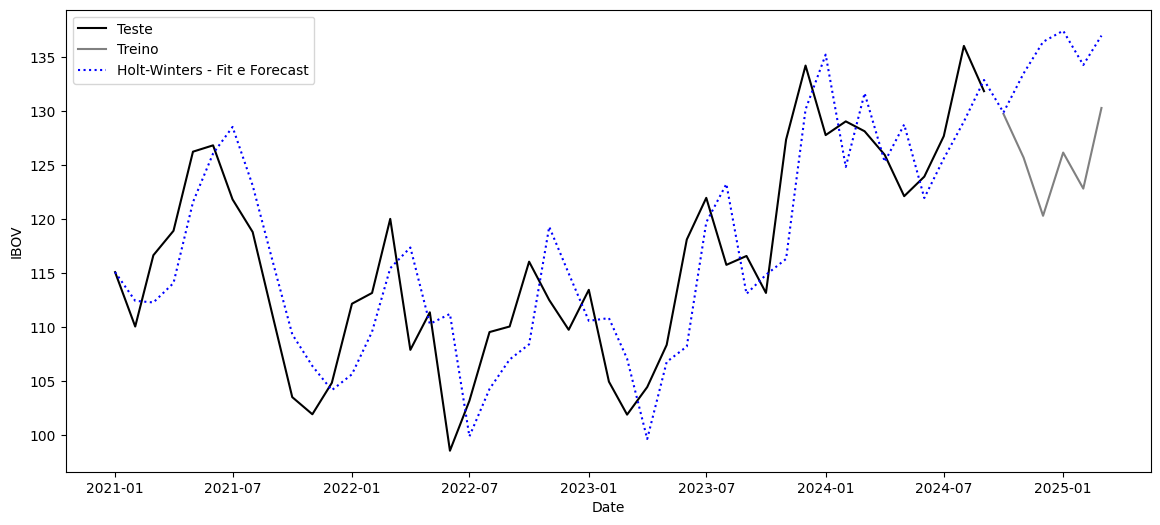

In [68]:
plt.figure(figsize = (14,6))

sns.lineplot(
    data = train_ndiff,
    label = 'Teste',
    color = 'black',
    x='Date',
    y='IBOV'
)

sns.lineplot(
    data = test_ndiff,
    label = 'Treino',
    color = 'grey',
    x='Date',
    y='IBOV'
)

sns.lineplot(
    data = fit_forecast,
    label = 'Holt-Winters - Fit e Forecast',
    color = 'blue',
    linestyle = 'dotted',
    x='Date',
    y='fitted'
)

plt.show()

In [69]:
print(mean_squared_error(
    forecast, test_ndiff['IBOV']
))

103.7757772871506


4. Tentando replicar o modelo!

A fórmula teórica do Prophet: y(t)=g(t)+s(t)+h(t)+εt​

y(t) sendo a previsão -- montada a partir os componentes abaixo -- ;

g(t) a tendência;

s(t) a sazonalidade;

h(t) os feriados e -- este iremos desconsiderar --;

εt​ os erros

4.1. Replicando a TREND

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [71]:
# O trend do Prophet é calculado com alguns changepoints; que são pontos nos quais a direção da série pode mudar

num_points = 3 # Usei 2 a princípio, mas 3 parecia permitir um formato melhor;

# Criando o vetor de tempo; que servirá como a única covariada para essa trend

X = pd.DataFrame([])

X['time'] = (train_ndiff['Date'] - train_ndiff['Date'].min()).dt.days

X.head()

,time
0,0
1,31
2,59
3,90
4,120


In [72]:
# No prophet, os changepoints são feitos em 80% do dataset;
  # Criaremos os changepoints linearmente com linspace
indices_points = np.linspace(
    0, int(len(train_ndiff) * 0.8), num_points +2, dtype = int
)[1:-1] # Adicionamos +2 e tiramos o 1 e -1 para que não tenhamos mudanças no início da série nem no final exato dos 80%

# Procuramos os indices equivalentes no df X (o do tempo)
changepoints = X['time'].iloc[indices_points].values

changepoints

array([273, 546, 820])

In [73]:
for i, cp in enumerate(changepoints):
    X[f'd_{i}'] = np.maximum(0, X['time'] - cp)

In [74]:
X

,time,d_0,d_1,d_2
0,0,0,0,0
1,31,0,0,0
2,59,0,0,0
3,90,0,0,0
4,120,0,0,0
5,151,0,0,0
6,181,0,0,0
7,212,0,0,0
8,243,0,0,0
9,273,0,0,0


In [75]:
y = train_ndiff['IBOV'].values

# Fit da reglin
model_trend = LinearRegression().fit(X, y)

In [76]:
train_ndiff['trend'] = model_trend.predict(X)

<ipython-input-76-e85e959793bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ndiff['trend'] = model_trend.predict(X)


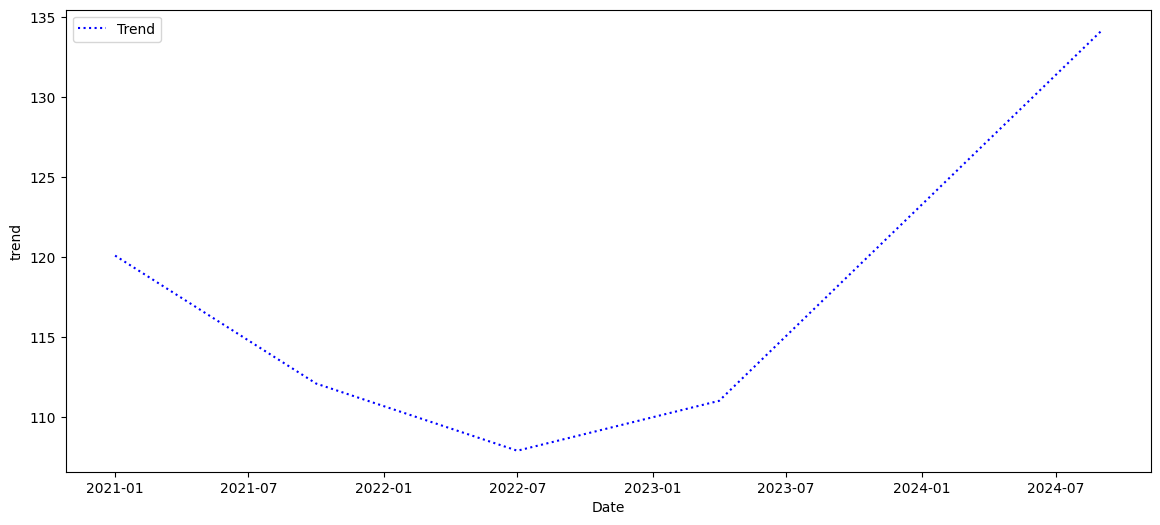

In [77]:
plt.figure(figsize = (14,6))


sns.lineplot(
    data = train_ndiff,
    label = 'Trend',
    color = 'blue',
    linestyle = 'dotted',
    x='Date',
    y='trend'
)


plt.show()

In [78]:
# Removendo a trend do y para ser capturada da sazonalidade

y_detrend = y - train_ndiff['trend']

4.2.1. Tentando encontrar a Sazonalidade de maneira simples usando a Série de Fourier, que é o que faz o próprio modelo Prophet

Não posso mentir, aqui o ChatGPT teve que me dar uma boa ajuda

In [79]:
def fourier_series(t, period, order):
  """
  Gera componentes Fourier (seno e cosseno) para modelar sazonalidade periódica.

  Parâmetros:
  - t: vetor de tempo (em dias, por exemplo)
  - period: período da sazonalidade (ex: 365.25 para anual)
  - order: número de termos (quanto maior, mais complexo o padrão)

  Retorna:
  - Um array com 2 * order colunas (seno e cosseno para cada harmônico)
  """
  x = []
  for i in range(1, order + 1):
    x.append(np.sin(2 * np.pi * i * t / period))
    x.append(np.cos(2 * np.pi * i * t / period))
  return np.column_stack(x)

In [80]:
fourier_order = 10
X_fourier = pd.DataFrame(
    fourier_series(X['time'].values, period=365.25, order=fourier_order),
    columns=[f'sin_{i}' if j % 2 == 0 else f'cos_{i}'
             for i in range(1, fourier_order + 1) for j in range(2)]
)

In [81]:
sigma = 10.0
alpha = 1 / sigma**2  # Ridge uses alpha = λ = 1/σ²

# Fit model
model_season = Ridge(alpha=alpha, fit_intercept=False)
model_season.fit(X_fourier, y_detrend)

Ridge(alpha=0.01, fit_intercept=False)

In [82]:
X_fourier

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,cos_5,sin_6,cos_6,sin_7,cos_7,sin_8,cos_8,sin_9,cos_9,sin_10,cos_10
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.508356,0.861147,0.875539,0.483147,0.999579,-0.029025,0.846029,-0.533137,0.457531,-0.889193,-0.058026,-0.998315,-0.557468,-0.830198,-0.902099,-0.431530,-0.996210,0.086977,-0.813668,0.581330
2,0.849450,0.527668,0.896456,-0.443132,0.096613,-0.995322,-0.794497,-0.607268,-0.935075,0.354450,-0.192322,0.981332,0.732111,0.681185,0.964945,-0.262452,0.286231,-0.958161,-0.662875,-0.748730
3,0.999745,0.022576,0.045141,-0.998981,-0.997707,-0.067683,-0.090190,0.995925,0.993635,0.112651,0.135055,-0.990838,-0.987537,-0.157390,-0.179645,0.983732,0.979425,0.201808,0.223868,-0.974619
4,0.880683,-0.473706,-0.834370,-0.551205,-0.090190,0.995925,0.919817,-0.392347,-0.781257,-0.624210,-0.179645,0.983732,0.951454,-0.307790,-0.721775,-0.692128,-0.267636,0.963520,0.975336,-0.220724
5,0.517586,-0.855631,-0.885725,0.464210,0.998123,0.061245,-0.822326,-0.569017,0.409093,0.912493,0.122261,-0.992498,-0.618313,0.785932,0.935835,-0.352439,-0.983147,-0.182817,0.746588,0.665287
6,0.027950,-0.999609,-0.055879,0.998438,0.083764,-0.996486,-0.111583,0.993755,0.139315,-0.990248,-0.166938,0.985967,0.194431,-0.980916,-0.221772,0.975099,0.248940,-0.968519,-0.275913,0.961183
7,-0.484089,-0.875019,0.847173,0.531317,-0.998497,-0.054805,0.900235,-0.435405,-0.576948,0.816781,0.109446,-0.993993,0.385413,0.922744,-0.783934,-0.620844,0.986501,0.163757,-0.942480,0.334263
8,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667,-0.848314,-0.529494,0.886721,-0.462305,-0.051584,0.998669,-0.834370,-0.551205,0.898354,-0.439273,-0.077334,0.997005,-0.819871,-0.572548
9,-0.999870,-0.016127,0.032249,-0.999480,0.998830,0.048363,-0.064464,0.997920,-0.996751,-0.080549,0.096613,-0.995322,0.993635,0.112651,-0.128661,0.991689,-0.989485,-0.144636,0.160575,-0.987024


In [83]:
# enfim, temos que 'prever' a sazonalidade com uma regressão linear

#model_season = LinearRegression().fit(X_fourier, y)
train_ndiff['season_fourier'] = model_season.predict(X_fourier)

<ipython-input-83-ee71df5263b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ndiff['season_fourier'] = model_season.predict(X_fourier)


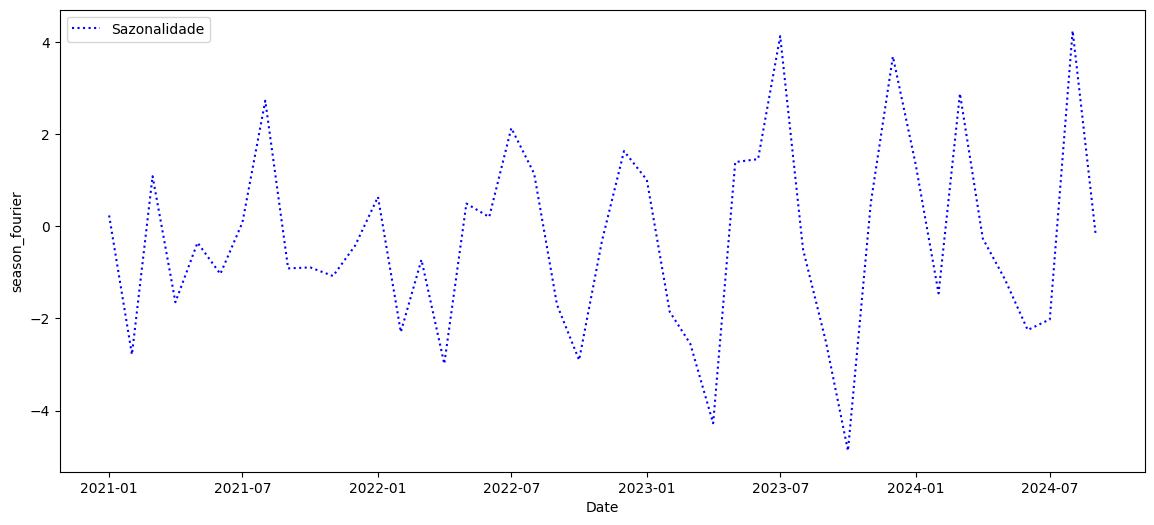

In [84]:
plt.figure(figsize = (14,6))


sns.lineplot(
    data = train_ndiff,
    label = 'Sazonalidade',
    color = 'blue',
    linestyle = 'dotted',
    x='Date',
    y='season_fourier'
)


plt.show()

In [87]:
# Somando as séries para capturar o fit final; compararemos com o fit do Prophet
  # Faremos o mesmo com regressão linear; O PREDICT AINDA NÃO ESTÁ AQUI!
train_ndiff['reconstr_1'] = train_ndiff['trend'] + train_ndiff['season_fourier']

train_ndiff.tail()

<ipython-input-87-a62904a46162>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ndiff['reconstr_1'] = train_ndiff['trend'] + train_ndiff['season_fourier']


,index,Date,IBOV,Change %,diff_1,fitted,trend,season_fourier,reconstr_1
40,40,2024-05-01,122.098,-3.04%,-0.030383,128.731427,128.676058,-1.148465,127.527593
41,41,2024-06-01,123.907,1.48%,0.014816,121.931468,130.056763,-2.250922,127.805841
42,42,2024-07-01,127.652,3.02%,0.030224,125.573255,131.392930,-2.020226,129.372703
43,43,2024-08-01,136.004,6.54%,0.065428,128.999709,132.773635,4.246709,137.020344
44,44,2024-09-01,131.816,-3.08%,-0.030793,132.850387,134.154340,-0.142605,134.011736


In [89]:
# Reconstruindo com Reg.Linear

X_rec = train_ndiff[['trend', 'season_fourier']]
y = train_ndiff['IBOV']
model_rec = LinearRegression()
model_rec.fit(X_rec, y)

train_ndiff['reconstr_2'] = model_rec.predict(X_rec)

<ipython-input-89-92736fdd8a09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ndiff['reconstr_2'] = model_rec.predict(X_rec)


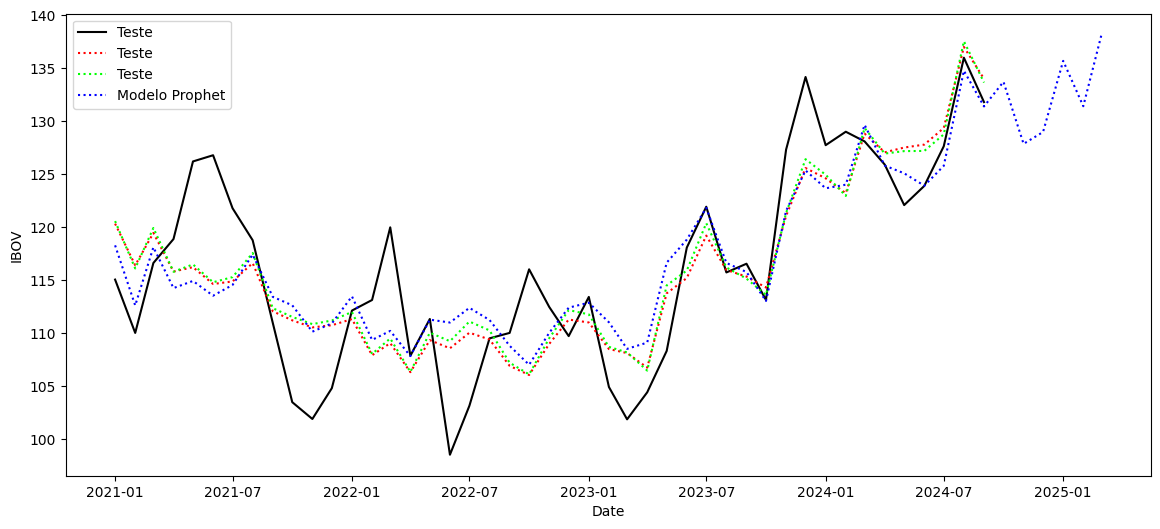

In [91]:
plt.figure(figsize = (14,6))

sns.lineplot(
    data = train_ndiff,
    label = 'Teste',
    color = 'black',
    x='Date',
    y='IBOV'
)

sns.lineplot(
    data = train_ndiff,
    label = 'Teste',
    color = 'red',
    linestyle = 'dotted',
    x='Date',
    y='reconstr_1'
)

sns.lineplot(
    data = train_ndiff,
    label = 'Teste',
    color = 'lime',
    linestyle = 'dotted',
    x='Date',
    y='reconstr_2'
)

sns.lineplot(
    data = forecast_prophet,
    label = 'Modelo Prophet',
    color = 'blue',
    linestyle = 'dotted',
    x='ds',
    y='yhat'
)

plt.show()